In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from expectation.confseq.confidencesequence import *
from expectation.modules.hypothesistesting import ( EValueConfig, Hypothesis, HypothesisType,
    LikelihoodRatioEValue
)


import scipy.stats as stats

### Create a helper plot function

In [2]:
def plot_three_panel_results(results, evalue_results, true_mean, title):
    """Plot confidence sequence results with e-values in three panels."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot 1: Confidence sequence
    sample_sizes = [r.sample_size for r in results]
    means = [r.state.running_mean for r in results]
    lowers = [r.lower for r in results]
    uppers = [r.upper for r in results]
    
    ax1.fill_between(sample_sizes, lowers, uppers, alpha=0.2, label='Confidence sequence')
    ax1.plot(sample_sizes, means, '--', label='Sample Mean')
    ax1.axhline(y=true_mean, color='r', linestyle='-', label='True Mean')
    ax1.set_xlabel('Sample Size')
    ax1.set_ylabel('Value')
    ax1.set_title(f'{title}\nConfidence Sequence')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Individual e-values
    evalues = [r.value for r in evalue_results]
    ax2.plot(sample_sizes, evalues, 'g-', label='E-value')
    ax2.axhline(y=1, color='k', linestyle='--', alpha=0.3, label='Null Value')
    ax2.set_xlabel('Sample Size')
    ax2.set_ylabel('E-value')
    ax2.set_title('Individual E-values')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: E-process (cumulative e-values)
    eprocess_values = np.cumprod([r.value for r in evalue_results])
    ax3.plot(sample_sizes, eprocess_values, 'b-', label='E-process')
    ax3.axhline(y=1/0.05, color='r', linestyle='--', 
                label='Rejection Threshold (1/α)', alpha=0.3)
    ax3.set_xlabel('Sample Size')
    ax3.set_ylabel('Cumulative E-value')
    ax3.set_title('E-process')
    ax3.set_yscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


### Example 1: Basic usage with normal mixture boundary


Example 1: Normal Mixture Boundary with Gaussian Data
After 25 samples:
  Mean estimate: 0.336
  Confidence sequence: [-0.540, 1.213]
  E-value: 0.745
  Significant: False
After 50 samples:
  Mean estimate: 0.275
  Confidence sequence: [-0.310, 0.859]
  E-value: 1.158
  Significant: False
After 75 samples:
  Mean estimate: 0.385
  Confidence sequence: [-0.096, 0.866]
  E-value: 0.357
  Significant: False
After 100 samples:
  Mean estimate: 0.396
  Confidence sequence: [0.003, 0.789]
  E-value: 0.945
  Significant: False
After 125 samples:
  Mean estimate: 0.428
  Confidence sequence: [0.069, 0.786]
  E-value: 0.423
  Significant: False
After 150 samples:
  Mean estimate: 0.418
  Confidence sequence: [0.088, 0.748]
  E-value: 0.864
  Significant: False
After 175 samples:
  Mean estimate: 0.450
  Confidence sequence: [0.149, 0.751]
  E-value: 0.958
  Significant: False
After 200 samples:
  Mean estimate: 0.459
  Confidence sequence: [0.178, 0.741]
  E-value: 1.094
  Significant: False
A

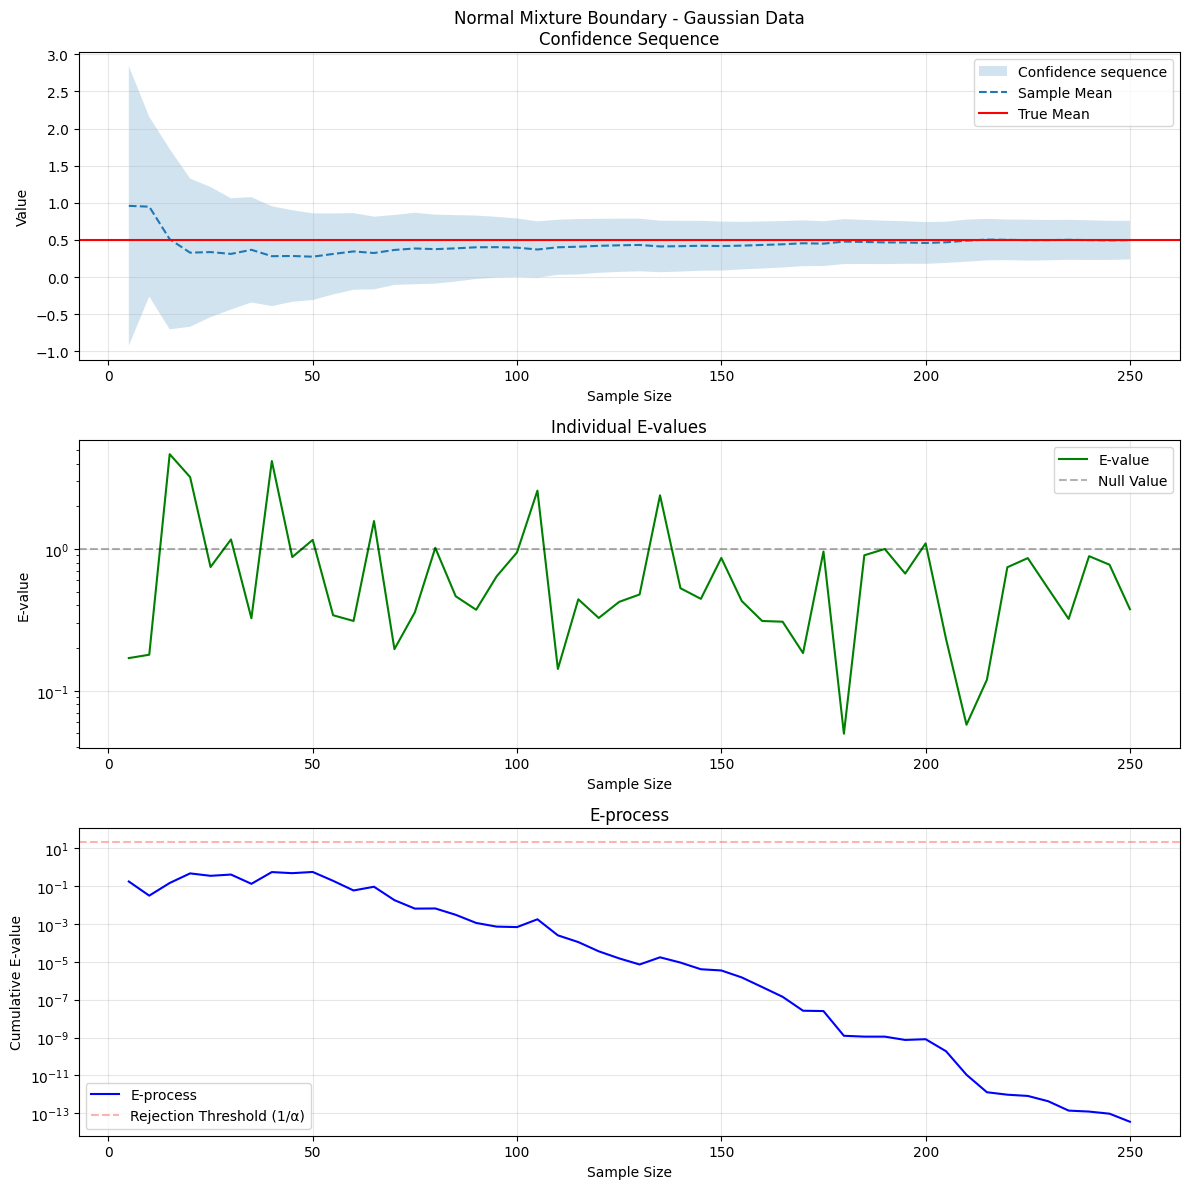

In [3]:
def example_normal_mixture():
    """Demonstrate basic confidence sequence with Gaussian data."""
    print("\nExample 1: Normal Mixture Boundary with Gaussian Data")
   
    # Configure confidence sequence
    config = ConfidenceSequenceConfig(
        alpha=0.05,
        boundary_type=BoundaryType.NORMAL_MIXTURE,
        rho=1.0
    )
    cs = ConfidenceSequence(config=config)
    
    # Configure e-value calculator
    null_hypothesis = Hypothesis(
        name="Mean Test",
        description="H0: μ = 0.5",
        type=HypothesisType.SIMPLE
    )
    evaluator = LikelihoodRatioEValue(
        null_hypothesis=null_hypothesis,
        null_density=lambda x: stats.norm.pdf(x, loc=0.5, scale=1.0),
        alt_density=lambda x: stats.norm.pdf(x, loc=0.0, scale=1.0),
        config=EValueConfig(significance_level=0.05)
    )
   
    # Generate data and update sequentially
    true_mean = 0.5
    np.random.seed(42)
    results = []
    evalue_results = []
   
    for t in range(50):
        batch_size = 5
        data = np.random.normal(true_mean, 1.0, size=batch_size)
       
        # Update confidence sequence
        cs_result = cs.update(data)
        results.append(cs_result)
        
        # Update e-value
        evalue_result = evaluator.test(data)
        evalue_results.append(evalue_result)
        
        # Print updates periodically
        if (t+1) % 5 == 0:
            print(f"After {cs_result.sample_size} samples:")
            print(f"  Mean estimate: {cs_result.state.running_mean:.3f}")
            print(f"  Confidence sequence: [{cs_result.lower:.3f}, {cs_result.upper:.3f}]")
            print(f"  E-value: {evalue_result.value:.3f}")
            print(f"  Significant: {evalue_result.significant}")
   
    plot_three_panel_results(results, evalue_results, true_mean, 
                           "Normal Mixture Boundary - Gaussian Data")


example_normal_mixture()

### Example 2: Empirical Bernstein bound with bounded data


Example 2: Empirical Bernstein with Bounded Data
After 25 samples:
  Mean estimate: 0.704
  Confidence sequence: [0.485, 0.923]
  E-value: 0.026
  Significant: False
After 50 samples:
  Mean estimate: 0.685
  Confidence sequence: [0.553, 0.816]
  E-value: 0.023
  Significant: False
After 75 samples:
  Mean estimate: 0.698
  Confidence sequence: [0.600, 0.797]
  E-value: 0.024
  Significant: False
After 100 samples:
  Mean estimate: 0.688
  Confidence sequence: [0.606, 0.769]
  E-value: 0.026
  Significant: False
After 125 samples:
  Mean estimate: 0.684
  Confidence sequence: [0.613, 0.755]
  E-value: 0.099
  Significant: False
After 150 samples:
  Mean estimate: 0.692
  Confidence sequence: [0.629, 0.755]
  E-value: 0.024
  Significant: False
After 175 samples:
  Mean estimate: 0.691
  Confidence sequence: [0.635, 0.747]
  E-value: 0.072
  Significant: False
After 200 samples:
  Mean estimate: 0.693
  Confidence sequence: [0.642, 0.744]
  E-value: 0.007
  Significant: False
After 225

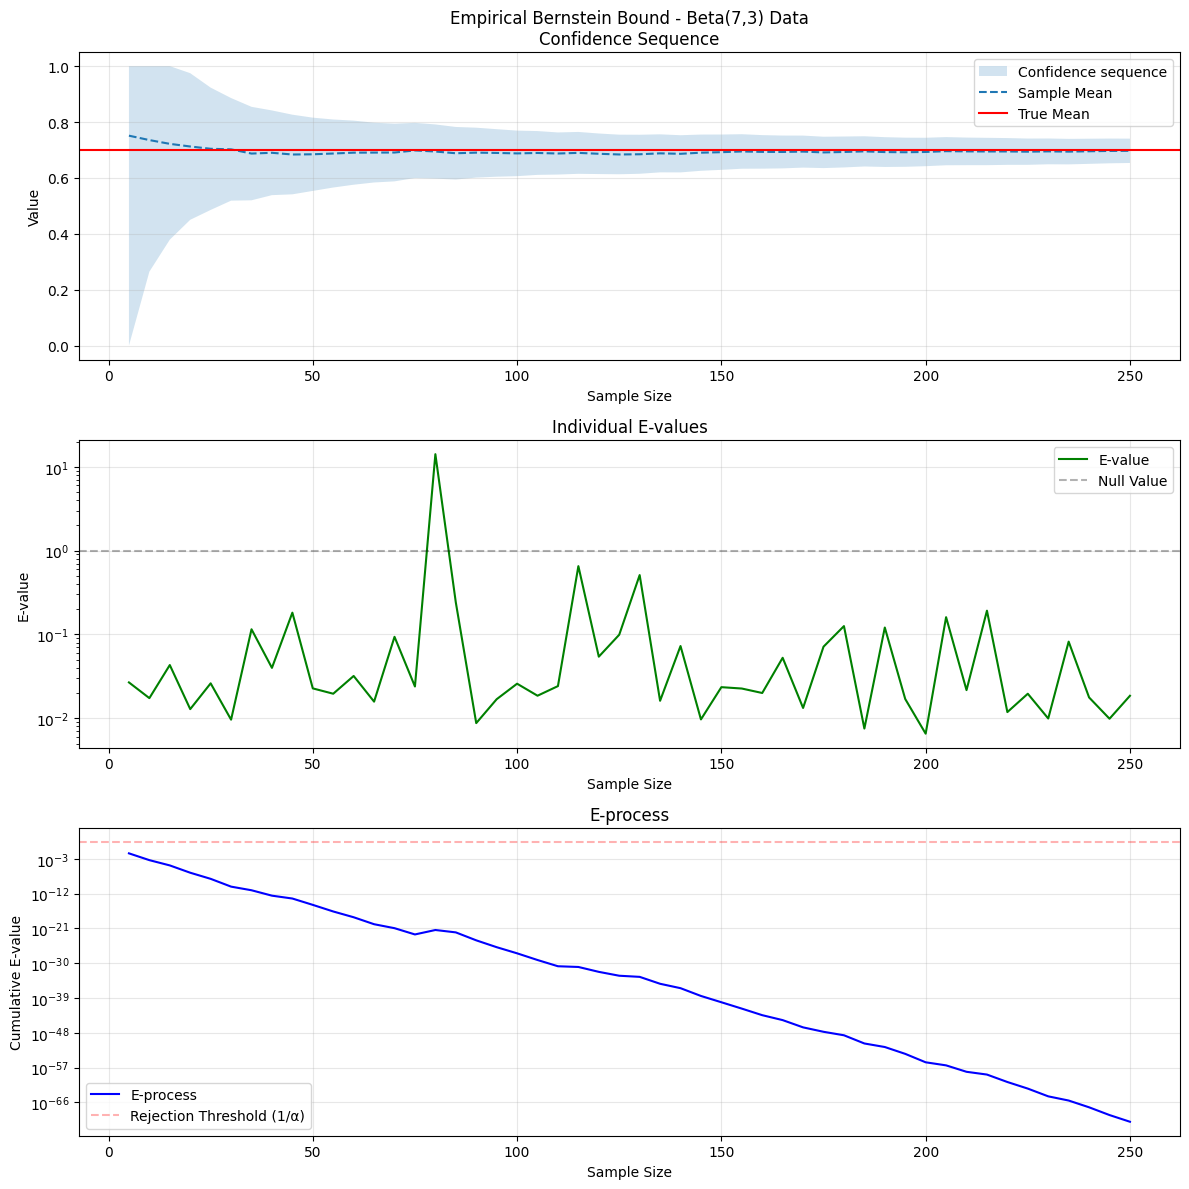

In [4]:
def example_empirical_bernstein():
    """Demonstrate empirical Bernstein confidence sequence with bounded data."""
    print("\nExample 2: Empirical Bernstein with Bounded Data")
   
    # Configure confidence sequence
    config = EmpiricalBernsteinConfig(
        alpha=0.05,
        boundary_type=BoundaryType.GAMMA_EXPONENTIAL,
        rho=2.0,
        lower_bound=0.0,
        upper_bound=1.0
    )
    cs = EmpiricalBernsteinConfidenceSequence(config=config)
    
    # Configure e-value calculator
    null_hypothesis = Hypothesis(
        name="Bounded Mean Test",
        description="H0: μ = 0.7",
        type=HypothesisType.SIMPLE
    )
    evaluator = LikelihoodRatioEValue(
        null_hypothesis=null_hypothesis,
        null_density=lambda x: stats.beta.pdf(x, a=7, b=3),
        alt_density=lambda x: stats.beta.pdf(x, a=1, b=1),
        config=EValueConfig(significance_level=0.05)
    )
   
    # Generate data and update sequentially
    true_mean = 0.7
    np.random.seed(42)
    results = []
    evalue_results = []  # Store e-value results
   
    for t in range(50):
        batch_size = 5
        data = np.random.beta(7, 3, size=batch_size)  # Beta distribution with mean 0.7
       
        # Update confidence sequence
        cs_result = cs.update(data)
        results.append(cs_result)
        
        # Update e-value
        evalue_result = evaluator.test(data)
        evalue_results.append(evalue_result)  # Store result
       
        # Print updates periodically
        if (t+1) % 5 == 0:
            print(f"After {cs_result.sample_size} samples:")
            print(f"  Mean estimate: {cs_result.state.running_mean:.3f}")
            print(f"  Confidence sequence: [{cs_result.lower:.3f}, {cs_result.upper:.3f}]")
            print(f"  E-value: {evalue_result.value:.3f}")
            print(f"  Significant: {evalue_result.significant}")
   
    # Pass evalue_results instead of evaluator
    plot_three_panel_results(results, evalue_results, true_mean,
                           "Empirical Bernstein Bound - Beta(7,3) Data")
    
example_empirical_bernstein()

### Example 3: Asymmetric bounded data with beta-binomial boundary


Example 3: Beta-Binomial Boundary with Skewed Data
After 25 samples:
  Mean estimate: 0.194
  Confidence sequence: [-0.016, 0.404]
  E-value: 0.004
  Significant: False
After 50 samples:
  Mean estimate: 0.181
  Confidence sequence: [0.055, 0.307]
  E-value: 0.016
  Significant: False
After 75 samples:
  Mean estimate: 0.184
  Confidence sequence: [0.088, 0.279]
  E-value: 0.007
  Significant: False
After 100 samples:
  Mean estimate: 0.181
  Confidence sequence: [0.105, 0.257]
  E-value: 0.011
  Significant: False
After 125 samples:
  Mean estimate: 0.189
  Confidence sequence: [0.124, 0.254]
  E-value: 0.033
  Significant: False
After 150 samples:
  Mean estimate: 0.185
  Confidence sequence: [0.129, 0.242]
  E-value: 0.004
  Significant: False
After 175 samples:
  Mean estimate: 0.189
  Confidence sequence: [0.138, 0.240]
  E-value: 0.022
  Significant: False
After 200 samples:
  Mean estimate: 0.190
  Confidence sequence: [0.143, 0.238]
  E-value: 0.008
  Significant: False
After 

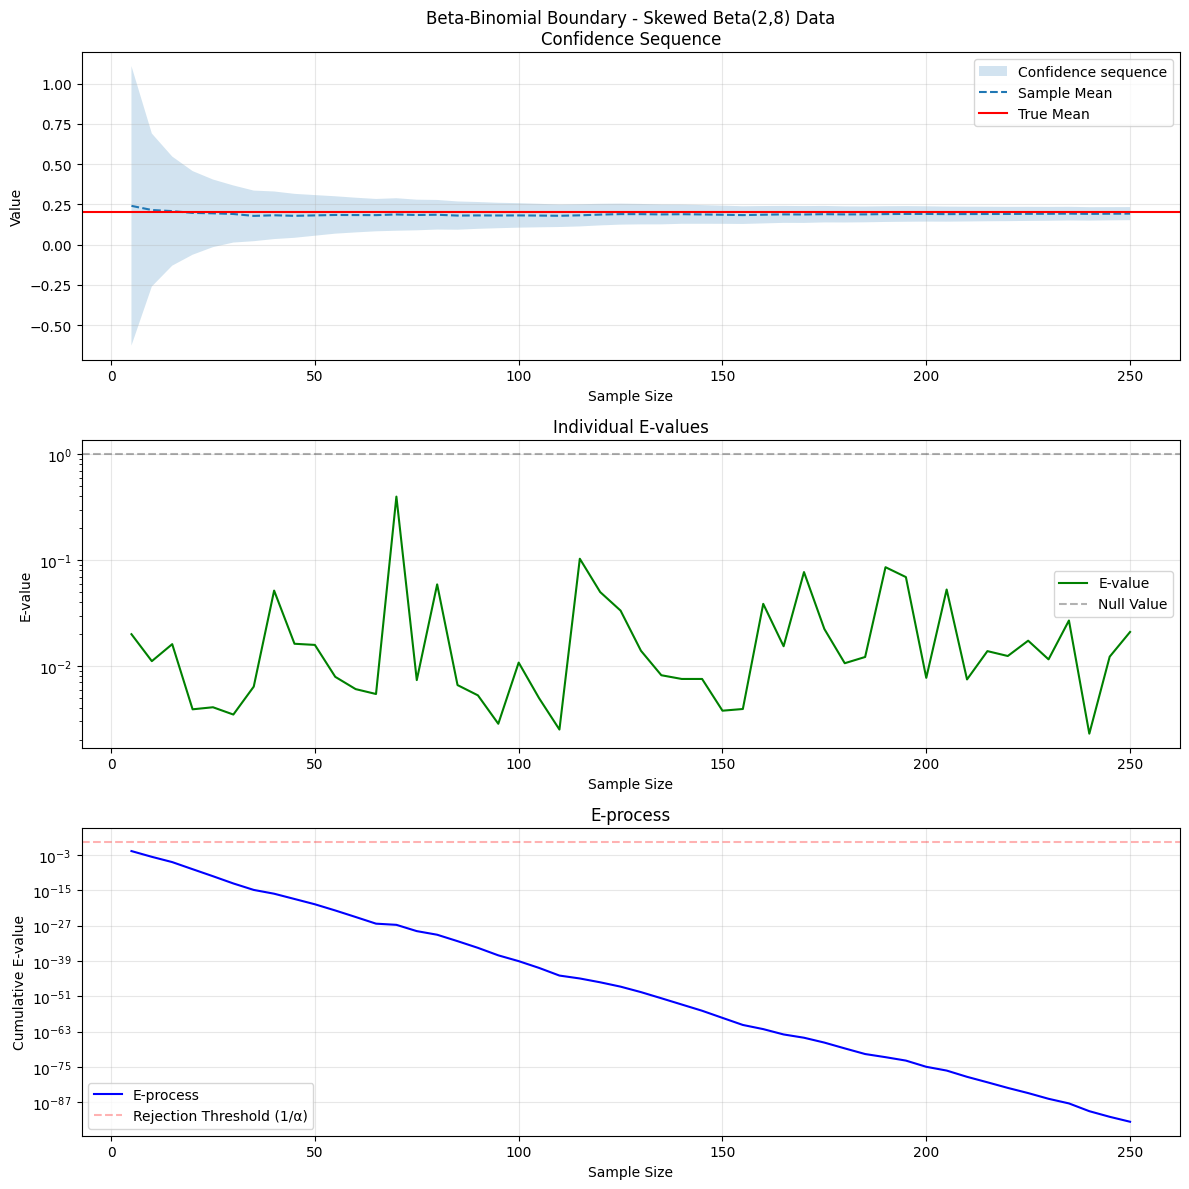

In [5]:
def example_beta_binomial():
    """Demonstrate beta-binomial boundary with skewed bounded data."""
    print("\nExample 3: Beta-Binomial Boundary with Skewed Data")
   
    config = ConfidenceSequenceConfig(
        alpha=0.05,
        boundary_type=BoundaryType.BETA_BINOMIAL,
        rho=1.5
    )
    cs = ConfidenceSequence(config=config)
    
    null_hypothesis = Hypothesis(
        name="Skewed Mean Test",
        description="H0: μ = 0.2",
        type=HypothesisType.SIMPLE
    )
    evaluator = LikelihoodRatioEValue(
        null_hypothesis=null_hypothesis,
        null_density=lambda x: stats.beta.pdf(x, a=2, b=8),
        alt_density=lambda x: stats.beta.pdf(x, a=1, b=1),
        config=EValueConfig(significance_level=0.05)
    )
   
    true_mean = 0.2
    np.random.seed(42)
    results = []
    evalue_results = []
   
    for t in range(50):
        batch_size = 5
        data = np.random.beta(2, 8, size=batch_size)
       
        cs_result = cs.update(data)
        results.append(cs_result)
        
        evalue_result = evaluator.test(data)
        evalue_results.append(evalue_result)
       
        if (t+1) % 5 == 0:
            print(f"After {cs_result.sample_size} samples:")
            print(f"  Mean estimate: {cs_result.state.running_mean:.3f}")
            print(f"  Confidence sequence: [{cs_result.lower:.3f}, {cs_result.upper:.3f}]")
            print(f"  E-value: {evalue_result.value:.3f}")
            print(f"  Significant: {evalue_result.significant}")
   
    plot_three_panel_results(results, evalue_results, true_mean,
                           "Beta-Binomial Boundary - Skewed Beta(2,8) Data")
    

example_beta_binomial()


### Example 4: Polynomial stitching boundary with heavy-tailed data


Example 4: Polynomial Stitching Boundary with Heavy-Tailed Data
After 25 samples:
  Mean estimate: 0.797
  Confidence sequence: [-0.192, 1.787]
  E-value: 1.495
  Significant: False
After 50 samples:
  Mean estimate: 0.811
  Confidence sequence: [0.210, 1.412]
  E-value: 0.106
  Significant: False
After 75 samples:
  Mean estimate: 0.775
  Confidence sequence: [0.297, 1.253]
  E-value: 3.954
  Significant: False
After 100 samples:
  Mean estimate: 0.836
  Confidence sequence: [0.420, 1.252]
  E-value: 0.256
  Significant: False
After 125 samples:
  Mean estimate: 0.958
  Confidence sequence: [0.562, 1.354]
  E-value: 2.731
  Significant: False
After 150 samples:
  Mean estimate: 0.993
  Confidence sequence: [0.607, 1.379]
  E-value: 0.783
  Significant: False
After 175 samples:
  Mean estimate: 1.009
  Confidence sequence: [0.649, 1.369]
  E-value: 0.453
  Significant: False
After 200 samples:
  Mean estimate: 0.962
  Confidence sequence: [0.626, 1.297]
  E-value: 5.970
  Significant:

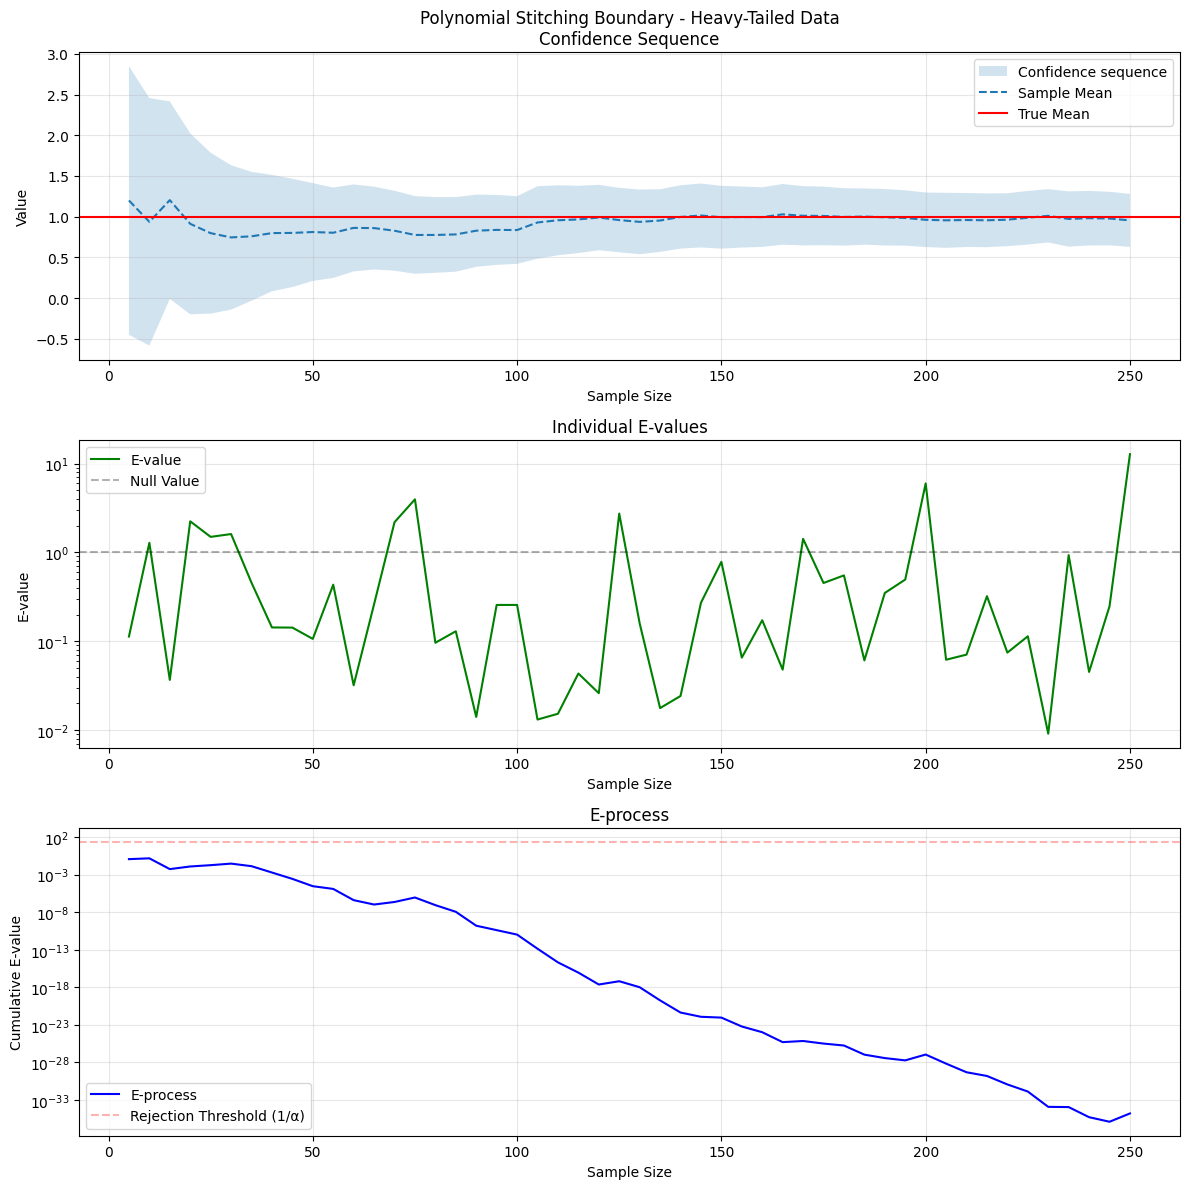

In [6]:
def example_poly_stitching():
    """Demonstrate polynomial stitching boundary with heavy-tailed data."""
    print("\nExample 4: Polynomial Stitching Boundary with Heavy-Tailed Data")
    
    # Configure confidence sequence with polynomial stitching
    config = ConfidenceSequenceConfig(
        alpha=0.05,
        boundary_type=BoundaryType.POLY_STITCHING,
        v_opt=1.0,
        c=0.1,
        alpha_opt=0.05
    )
    cs = ConfidenceSequence(config=config)
    
    # Configure e-value calculator using poly stitching bound
    null_hypothesis = Hypothesis(
        name="Heavy-Tailed Mean Test",
        description="H0: μ = 1.0",
        type=HypothesisType.SIMPLE
    )
    
    # Using the existing PolyStitchingBound from your codebase
    poly_bound = boundaries.poly_stitching_bound
    
    evaluator = LikelihoodRatioEValue(
        null_hypothesis=null_hypothesis,
        null_density=lambda x: stats.t.pdf(x - 1.0, df=3),  # null centered at 1.0
        alt_density=lambda x: stats.t.pdf(x, df=3),         # alternative centered at 0
        config=EValueConfig(significance_level=0.05)
    )
    
    # Generate data and update sequentially
    true_mean = 1.0
    np.random.seed(42)
    results = []
    evalue_results = []
    
    for t in range(50):
        # Generate batch of heavy-tailed observations
        batch_size = 5
        data = true_mean + np.random.standard_t(df=3, size=batch_size)
        
        # Update confidence sequence
        cs_result = cs.update(data)
        results.append(cs_result)
        
        # Update e-value
        evalue_result = evaluator.test(data)
        evalue_results.append(evalue_result)
        
        # Print updates periodically
        if (t+1) % 5 == 0:
            print(f"After {cs_result.sample_size} samples:")
            print(f"  Mean estimate: {cs_result.state.running_mean:.3f}")
            print(f"  Confidence sequence: [{cs_result.lower:.3f}, {cs_result.upper:.3f}]")
            print(f"  E-value: {evalue_result.value:.3f}")
            print(f"  Significant: {evalue_result.significant}")
    
    plot_three_panel_results(results, evalue_results, true_mean, 
                           "Polynomial Stitching Boundary - Heavy-Tailed Data")
    
example_poly_stitching()

### Example 5: Discrete mixture boundary with mixture distribution


Example 5: Discrete Mixture Boundary with Mixture Distribution
After 25 samples:
  Mean estimate: 1.472
  Confidence sequence: [0.533, 2.411]
  E-value: 0.009
  Significant: False
After 50 samples:
  Mean estimate: 1.449
  Confidence sequence: [0.823, 2.075]
  E-value: 0.000
  Significant: False
After 75 samples:
  Mean estimate: 1.365
  Confidence sequence: [0.840, 1.890]
  E-value: 2.354
  Significant: False
After 100 samples:
  Mean estimate: 1.410
  Confidence sequence: [0.962, 1.859]
  E-value: 0.000
  Significant: False
After 125 samples:
  Mean estimate: 1.372
  Confidence sequence: [0.980, 1.765]
  E-value: 0.000
  Significant: False
After 150 samples:
  Mean estimate: 1.401
  Confidence sequence: [1.045, 1.757]
  E-value: 0.002
  Significant: False
After 175 samples:
  Mean estimate: 1.460
  Confidence sequence: [1.137, 1.784]
  E-value: 0.000
  Significant: False
After 200 samples:
  Mean estimate: 1.444
  Confidence sequence: [1.147, 1.741]
  E-value: 0.005
  Significant: F

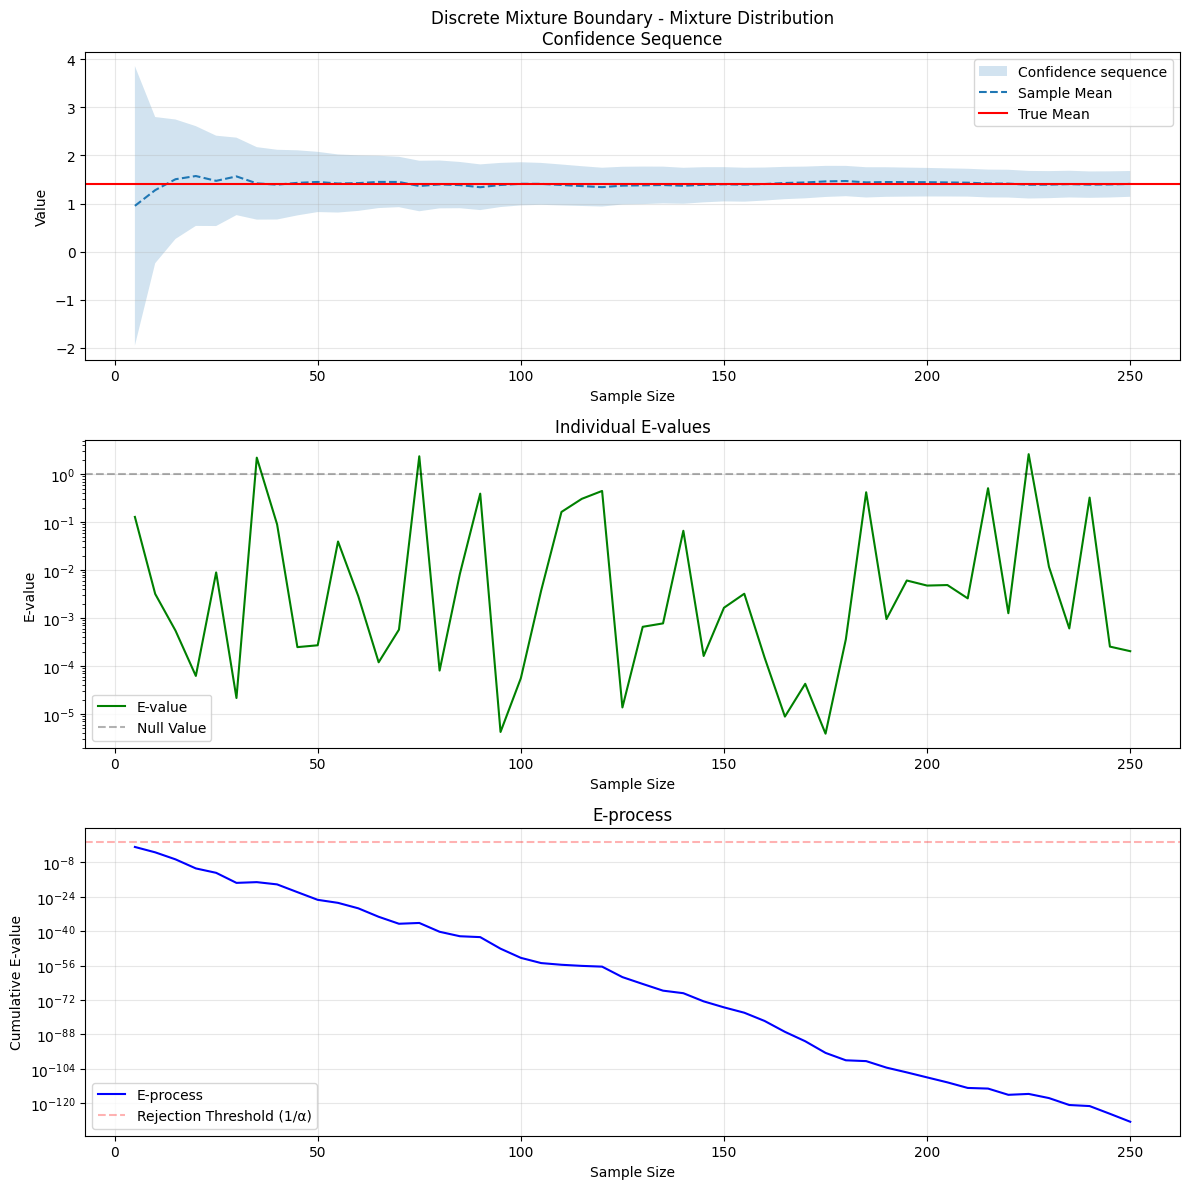

In [7]:
def example_discrete_mixture():
    """Demonstrate discrete mixture boundary with mixture distribution data."""
    print("\nExample 5: Discrete Mixture Boundary with Mixture Distribution")
    
    # Configure confidence sequence with discrete mixture
    config = ConfidenceSequenceConfig(
        alpha=0.05,
        boundary_type=BoundaryType.DISCRETE_MIXTURE,
        v_opt=2.0,
        c=1.0,
        alpha_opt=0.05
    )
    cs = ConfidenceSequence(config=config)
    
    # Configure e-value calculator
    null_hypothesis = Hypothesis(
        name="Mixture Mean Test",
        description="H0: μ = 1.4",
        type=HypothesisType.SIMPLE
    )
    
    # Using your existing two-sided normal mixture
    evaluator = LikelihoodRatioEValue(
        null_hypothesis=null_hypothesis,
        null_density=lambda x: (
            0.3 * stats.norm.pdf(x, loc=0, scale=0.5) + 
            0.7 * stats.norm.pdf(x, loc=2, scale=0.5)
        ),
        alt_density=lambda x: stats.norm.pdf(x, loc=0, scale=1),
        config=EValueConfig(significance_level=0.05)
    )
    
    # True mean = 0.3 * 0 + 0.7 * 2 = 1.4
    true_mean = 1.4
    np.random.seed(42)
    results = []
    evalue_results = []
    
    for t in range(50):
        # Generate batch from mixture distribution
        batch_size = 5
        mixture_indicators = np.random.binomial(1, 0.7, size=batch_size)
        data = np.where(mixture_indicators == 1,
                       np.random.normal(2, 0.5, size=batch_size),
                       np.random.normal(0, 0.5, size=batch_size))
        
        # Update confidence sequence
        cs_result = cs.update(data)
        results.append(cs_result)
        
        # Update e-value
        evalue_result = evaluator.test(data)
        evalue_results.append(evalue_result)
        
        # Print updates periodically
        if (t+1) % 5 == 0:
            print(f"After {cs_result.sample_size} samples:")
            print(f"  Mean estimate: {cs_result.state.running_mean:.3f}")
            print(f"  Confidence sequence: [{cs_result.lower:.3f}, {cs_result.upper:.3f}]")
            print(f"  E-value: {evalue_result.value:.3f}")
            print(f"  Significant: {evalue_result.significant}")
    
    plot_three_panel_results(results, evalue_results, true_mean,
                           "Discrete Mixture Boundary - Mixture Distribution")
    
example_discrete_mixture()

### Example 6: Combined comparison of different boundaries


Comprehensive Comparison of All Examples


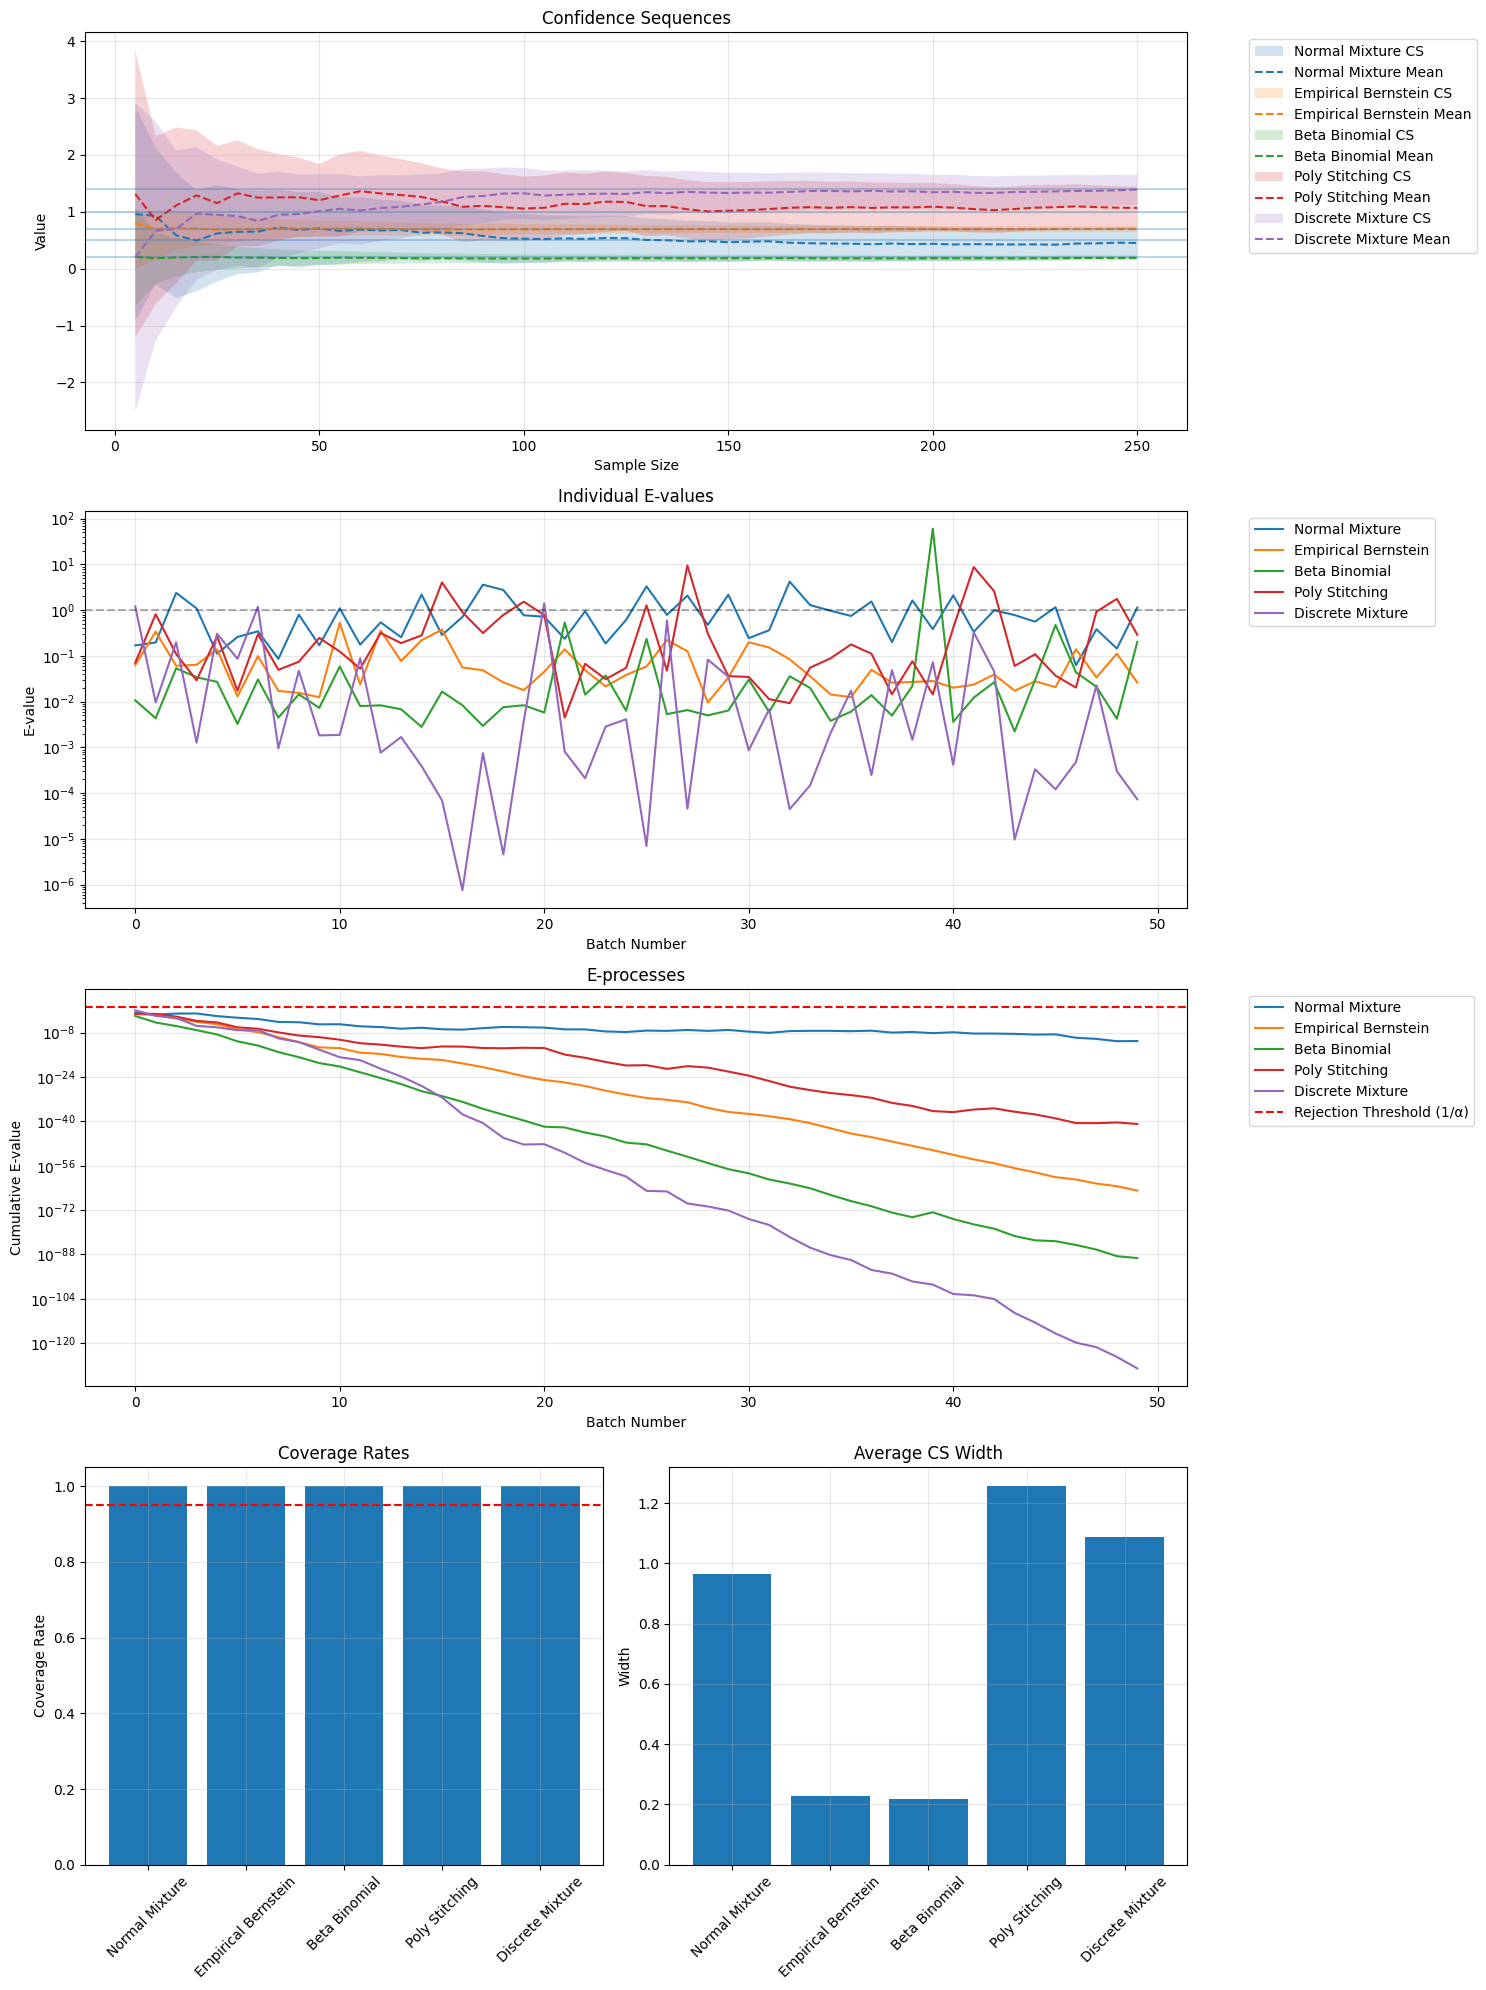


Summary Statistics:

Coverage Rates:
Normal Mixture: 1.000
Empirical Bernstein: 1.000
Beta Binomial: 1.000
Poly Stitching: 1.000
Discrete Mixture: 1.000

Average CS Widths:
Normal Mixture: 0.966
Empirical Bernstein: 0.227
Beta Binomial: 0.218
Poly Stitching: 1.257
Discrete Mixture: 1.089


In [8]:
def compare_all_examples():
    """Compare all boundary types with their respective data distributions."""
    print("\nComprehensive Comparison of All Examples")
    
    # Define example configurations
    examples = {
        "Normal Mixture": {
            "config": ConfidenceSequenceConfig(
                alpha=0.05,
                boundary_type=BoundaryType.NORMAL_MIXTURE,
                v_opt=1.0,
                c=1.0,
                alpha_opt=0.05
            ),
            "null_hypothesis": Hypothesis(
                name="Normal Mean Test",
                description="H0: μ = 0.5",
                type=HypothesisType.SIMPLE
            ),
            "true_mean": 0.5,
            "data_generator": lambda size: np.random.normal(0.5, 1.0, size=size),
            "null_density": lambda x: stats.norm.pdf(x, loc=0.5, scale=1.0),
            "alt_density": lambda x: stats.norm.pdf(x, loc=0.0, scale=1.0)
        },
        
        "Empirical Bernstein": {
            "config": EmpiricalBernsteinConfig(
                alpha=0.05,
                boundary_type=BoundaryType.GAMMA_EXPONENTIAL,
                v_opt=1.0,
                c=1.0,
                alpha_opt=0.05,
                lower_bound=0.0,
                upper_bound=1.0,
                rho=2.0
            ),
            "null_hypothesis": Hypothesis(
                name="Bounded Mean Test",
                description="H0: μ = 0.7",
                type=HypothesisType.SIMPLE
            ),
            "true_mean": 0.7,
            "data_generator": lambda size: np.random.beta(7, 3, size=size),
            "null_density": lambda x: stats.beta.pdf(x, a=7, b=3),
            "alt_density": lambda x: stats.beta.pdf(x, a=1, b=1)
        },
        
        "Beta Binomial": {
            "config": ConfidenceSequenceConfig(
                alpha=0.05,
                boundary_type=BoundaryType.BETA_BINOMIAL,
                v_opt=1.0,
                c=1.0,
                alpha_opt=0.05
            ),
            "null_hypothesis": Hypothesis(
                name="Skewed Mean Test",
                description="H0: μ = 0.2",
                type=HypothesisType.SIMPLE
            ),
            "true_mean": 0.2,
            "data_generator": lambda size: np.random.beta(2, 8, size=size),
            "null_density": lambda x: stats.beta.pdf(x, a=2, b=8),
            "alt_density": lambda x: stats.beta.pdf(x, a=1, b=1)
        },
        
        "Poly Stitching": {
            "config": ConfidenceSequenceConfig(
                alpha=0.05,
                boundary_type=BoundaryType.POLY_STITCHING,
                v_opt=1.0,
                c=0.1,
                alpha_opt=0.05
            ),
            "null_hypothesis": Hypothesis(
                name="Heavy-Tailed Mean Test",
                description="H0: μ = 1.0",
                type=HypothesisType.SIMPLE
            ),
            "true_mean": 1.0,
            "data_generator": lambda size: 1.0 + np.random.standard_t(df=3, size=size),
            "null_density": lambda x: stats.t.pdf(x - 1.0, df=3),
            "alt_density": lambda x: stats.t.pdf(x, df=3)
        },
        
        "Discrete Mixture": {
            "config": ConfidenceSequenceConfig(
                alpha=0.05,
                boundary_type=BoundaryType.DISCRETE_MIXTURE,
                v_opt=2.0,
                c=1.0,
                alpha_opt=0.05
            ),
            "null_hypothesis": Hypothesis(
                name="Mixture Mean Test",
                description="H0: μ = 1.4",
                type=HypothesisType.SIMPLE
            ),
            "true_mean": 1.4,
            "data_generator": lambda size: np.where(
                np.random.binomial(1, 0.7, size=size),
                np.random.normal(2, 0.5, size=size),
                np.random.normal(0, 0.5, size=size)
            ),
            "null_density": lambda x: (
                0.3 * stats.norm.pdf(x, loc=0, scale=0.5) + 
                0.7 * stats.norm.pdf(x, loc=2, scale=0.5)
            ),
            "alt_density": lambda x: stats.norm.pdf(x, loc=0, scale=1)
        }
    }
    
    # Initialize results storage
    results_dict = {name: [] for name in examples.keys()}
    evalue_results_dict = {name: [] for name in examples.keys()}
    coverage_dict = {name: 0 for name in examples.keys()}
    avg_width_dict = {name: [] for name in examples.keys()}
    
    # Run simulations
    np.random.seed(42)
    n_batches = 50
    batch_size = 5
    
    for t in range(n_batches):
        for name, example in examples.items():
            # Setup if first iteration
            if t == 0:
                if isinstance(example["config"], EmpiricalBernsteinConfig):
                    cs = EmpiricalBernsteinConfidenceSequence(config=example["config"])
                else:
                    cs = ConfidenceSequence(config=example["config"])
                
                evaluator = LikelihoodRatioEValue(
                    null_hypothesis=example["null_hypothesis"],
                    null_density=example["null_density"],
                    alt_density=example["alt_density"],
                    config=EValueConfig(significance_level=0.05)
                )
                results_dict[name].append(("cs", cs))
                results_dict[name].append(("evaluator", evaluator))
                results_dict[name].append(("results", []))
                results_dict[name].append(("evalues", []))
            else:
                cs = [item[1] for item in results_dict[name] if item[0] == "cs"][0]
                evaluator = [item[1] for item in results_dict[name] if item[0] == "evaluator"][0]
            
            # Generate and process data
            data = example["data_generator"](batch_size)
            
            # Update confidence sequence
            cs_result = cs.update(data)
            [item[1] for item in results_dict[name] if item[0] == "results"][0].append(cs_result)
            
            # Update e-value
            evalue_result = evaluator.test(data)
            [item[1] for item in results_dict[name] if item[0] == "evalues"][0].append(evalue_result)
            
            # Track coverage and width
            coverage_dict[name] += (
                cs_result.lower <= example["true_mean"] <= cs_result.upper
            )
            avg_width_dict[name].append(cs_result.upper - cs_result.lower)
    
    # Plot comparisons
    plot_comprehensive_comparison(
        results_dict,
        examples,
        coverage_dict,
        avg_width_dict,
        n_batches
    )

def plot_comprehensive_comparison(results_dict, examples, coverage_dict, 
                                avg_width_dict, n_batches):
    """Plot comprehensive comparison of all methods."""
    fig = plt.figure(figsize=(15, 20))
    gs = GridSpec(4, 2, figure=fig)
    
    # Plot 1: Confidence sequence
    ax1 = fig.add_subplot(gs[0, :])
    for name in examples.keys():
        results = [item[1] for item in results_dict[name] if item[0] == "results"][0]
        sample_sizes = [r.sample_size for r in results]
        means = [r.state.running_mean for r in results]
        lowers = [r.lower for r in results]
        uppers = [r.upper for r in results]
        
        ax1.fill_between(sample_sizes, lowers, uppers, alpha=0.2, 
                        label=f"{name} CS")
        ax1.plot(sample_sizes, means, '--', label=f"{name} Mean")
        ax1.axhline(y=examples[name]["true_mean"], linestyle='-', alpha=0.3)
    
    ax1.set_title("Confidence Sequences")
    ax1.set_xlabel("Sample Size")
    ax1.set_ylabel("Value")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Individual E-values
    ax2 = fig.add_subplot(gs[1, :])
    for name in examples.keys():
        evalues = [item[1] for item in results_dict[name] if item[0] == "evalues"][0]
        sample_sizes = range(len(evalues))
        e_values = [r.value for r in evalues]
        ax2.plot(sample_sizes, e_values, '-', label=name)
    
    ax2.axhline(y=1, color='k', linestyle='--', alpha=0.3)
    ax2.set_title("Individual E-values")
    ax2.set_xlabel("Batch Number")
    ax2.set_ylabel("E-value")
    ax2.set_yscale('log')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: E-processes
    ax3 = fig.add_subplot(gs[2, :])
    for name in examples.keys():
        evalues = [item[1] for item in results_dict[name] if item[0] == "evalues"][0]
        sample_sizes = range(len(evalues))
        eprocess_values = np.cumprod([r.value for r in evalues])
        ax3.plot(sample_sizes, eprocess_values, '-', label=name)
    
    ax3.axhline(y=1/0.05, color='r', linestyle='--', 
                label='Rejection Threshold (1/α)')
    ax3.set_title("E-processes")
    ax3.set_xlabel("Batch Number")
    ax3.set_ylabel("Cumulative E-value")
    ax3.set_yscale('log')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Performance Metrics
    ax4 = fig.add_subplot(gs[3, 0])
    coverage_rates = {name: count/n_batches for name, count in coverage_dict.items()}
    ax4.bar(coverage_rates.keys(), coverage_rates.values())
    ax4.set_title("Coverage Rates")
    ax4.set_ylabel("Coverage Rate")
    ax4.tick_params(axis='x', rotation=45)
    ax4.axhline(y=0.95, color='r', linestyle='--', label='Target (95%)')
    ax4.grid(True, alpha=0.3)
    
    ax5 = fig.add_subplot(gs[3, 1])
    avg_widths = {name: np.mean(widths) for name, widths in avg_width_dict.items()}
    ax5.bar(avg_widths.keys(), avg_widths.values())
    ax5.set_title("Average CS Width")
    ax5.set_ylabel("Width")
    ax5.tick_params(axis='x', rotation=45)
    ax5.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nCoverage Rates:")
    for name, rate in coverage_rates.items():
        print(f"{name}: {rate:.3f}")
    
    print("\nAverage CS Widths:")
    for name, width in avg_widths.items():
        print(f"{name}: {width:.3f}")

compare_all_examples()